In [9]:
# Standard library imports
import warnings
from pathlib import Path
import joblib

# Third-party imports
import pandas as pd
import pickle

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from settings import config
from pull_taq import get_taq_nbbo, get_taq_wct
from transform_taq import extract_features_taq
from strategy import (
    create_labels,
    train_ml_model_pipeline,
    signal_to_returns
)
import numpy as np

from portfolio_stats import *
from sign_trading import run_intraday_hft_pipeline_with_plots, single_param_sensitivity

In [10]:
# Change default pandas display options

pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 200
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.expand_frame_repr', False)

# Global variables
RAW_DATA_DIR = Path(config("RAW_DATA_DIR"))
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR = Path(config("OUTPUT_DIR"))
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR = Path(config("PROCESSED_DATA_DIR"))
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
WRDS_USERNAME = config("WRDS_USERNAME")

print(PROCESSED_DATA_DIR)

/Users/willduckett/Documents/GitHub/quant-trading-final-project-2/data/processed


## Breakdown of the workflow of the function

## 1. Load TAQ data

### 1.1. Quotes Data

Pull quotes data from TAQ database (NBBO)

### 1.2. Trades Data

Pull quotes data from Trades database (WCT)


---
---
## 2. Data Preparation & Feature Engineering

#### 2.1. Merge Quotes and Trades

Asof-join of quotes and trades dataframes
- Match each trade with the most recent quote, keeping only rows with actual trades (left join) (that naturally discards pure-quote timestamps that lack trades.)
- Display first 5 rows to confirm data is loaded correctly

### 2.2. Feature Engineering

---
#### **Duration since last trade**:
- Time since the last trade.

---
#### **Mid price**:
- Average of the best bid and ask prices.
$$MP = \frac{\text{best bid price} + \text{best ask price}}{2}$$

---
#### **EWMA Price Returns**:
- To mitigate tick sensitivity, we can compute returns using an exponentially weighted moving average (EWMA) of past prices.
$$
r_t^{(T)} = \log \left( \frac{P_t}{\text{EWMA} \left(P, \lambda = \frac{1}{T} \right)} \right)
$$
- This smooths out price fluctuations and provides a more stable return measure.


---
#### **Order-weighted average price**:
- Weighted average of the best bid and ask prices.
$$
OWA = \frac{\sqrt{\text{ask size}}}{\sqrt{\text{ask size} + \text{bid size}}} \times \text{best bid price} + \frac{\sqrt{\text{bid size}}}{\sqrt{\text{ask size} + \text{bid size}}} \times \text{best ask price}
$$

---
#### **Spread**:
- Difference between the best ask and bid prices.
$$\text{Spread} = \text{best ask price} - \text{best bid price}$$

---
#### **Rolling Spread Mean, Coefficient of Variation & Z-score**:
- Instead of just using the instantaneous spread, we track its mean, coefficient of variation and z-score over a given rolling time period.
$$
\text{Spread Mean}_t = \frac{1}{T} \sum_{i=t-T}^{t} \text{Spread}_i
$$
$$
\text{Spread CV}_t = \frac{\text{Spread Std}_t}{\text{Spread Mean}_t}
$$
$$
\text{Spread Z-score}_t = \frac{\text{Spread}_t - \text{Spread Mean}_t}{\text{Spread Std}_t}
$$

$$\frac{\text{Spread Std}_t} = \sqrt{\frac{1}{T} \sum_{i=t-T}^{t} (\text{Spread}_i - \text{Spread Mean}_t)^2}$$

- This helps detect **spread widening** events, spread instability (CV) and liquidity shocks.

---
#### **Trade direction (sign)**:
- we mark trades with +1 for buyer-initiated, -1 for seller-initiated.
    - Find the best bid and offer as of the trade time
    - Compare the trade price to them
    - If the trade price equals the best bid, mark as seller-initiated
    - If the trade price equals the best offer, mark as buyer-initiated
    - Otherwise, mark according to whether trade price was below or above mid price

---
#### **Size imbalance**:
- A common intuition among traders is that the order sizes displayed at the top of the book reflect the general intention of the market. When the number of shares at the bid exceeds that at the ask, participants  expect the next price movement to be upwards, and vice versa. 

$$\text{SI} = \frac{\text{ask size} - \text{bid size}}{\text{ask size} + \text{bid size}}$$

---
#### **Order imbalance**:
- The order imbalance is the absolute difference between the volume of buyer-initiated and seller-initiated trades, divided by their sum over a _fixed volume bucket_.
- This metric is designed to measure market stress, not directional bias, which is why we take the absolute value—positive and negative imbalances would cancel each other out, potentially understating the overall level of informed trading.

$$\text{I}_n = \frac{\left| V_n^B - V_n^S \right|}{V_n^B + V_n^S}$$

(_where $V_n^B$ and $V_n^S$ are the volume of buyer-initiated and seller-initiated trades in the _n-th fixed volume bucket_, respectively._)

---
#### **Volume-weighted probability of informed trading (VPIN)**:
- The rolling average of Order Imbalance over the last _$N$ volume buckets_.

$$VPIN = \frac{1}{N} \sum_{n=1}^{N} I_n$$

where each $OI_n$ corresponds to the order imbalance calculated for a fixed-volume bucket, ensuring that VPIN reflects market activity in a volume-synchronized manner rather than fixed time or trade intervals.

---
#### **Trade Flow**:
- An extension of the VPIN, a running tally of signed trade sizes where the sign is defined as 1 if the trade was seller-initiated and -1 if it was buyer-initiated.
- At any moment, we examine all reported trades within the last time period of length $\tau$.
- The essential idea behind flow as a quantitative metric is that, in circumstances when many sellers are willing to cross that market-making bid-offer spread to complete their transactions, there is likely to be new information driving their choices. We do not know exactly what it is, but we certainly want to adapt to it.

- When flow has a stable sign over macroscopic periods of time, it is a manifestation of supply and demand imbalance, and so it (usually) corresponds to steady price movements over a given time period.

$$F_t^{(\tau)} = V_{(t-\tau, t)}^B - V_{(t-\tau, t)}^S$$

---
#### **Order Flow Imbalance (OFI)**:
- A measure of excess buying or selling pressure at the top of the order book, it represents the changes in supply and demand at the best bid and ask prices.
$$
\text{OFI} = (\text{Best Bid Size}_{t} - \text{Best Bid Size}_{t-1}) - (\text{Best Ask Size}_{t} - \text{Best Ask Size}_{t-1})
$$
- Best bid or size at the best bid increase -> increase in demand.
- Best bid or size at the best bid decreases -> decrease in demand.
- Best ask decreases or size at the best ask increases -> increase in supply.
- Best ask increases or size at the best ask decreases -> decrease in supply.

---
#### **Market Pressure (MP)**:
- Captures the aggressiveness of market orders relative to available liquidity.
- Higher values indicate stronger directional pressure.
$$
\text{MP}_t = \frac{\text{Trade Volume}_t}{\text{Bid Size}_t + \text{Ask Size}_t}


---
---
## 3. Machine Learning Model for Trade Signal Prediction

**Overview**

This section outlines the end-to-end pipeline for building a machine learning model to predict trade signals based on market microstructure features. The objective is to classify each time step into one of three categories:  
- **Buy signal (+1)** → Indicates a likely upward price movement.  
- **Hold signal (0)** → No action recommended.  
- **Sell signal (-1)** → Indicates a likely downward price movement.  

We achieve this through feature engineering, time-series cross-validation, model training, and performance evaluation.

---

#### 3.1. Future Return Calculation & Signal Labeling
To train a classification model, we first compute the **future return** based on the future VWAP and the current price. This helps us create a label for supervised learning.

**Steps:**

1. _Compute the log future return:_
   \[
   \text{future\_return}_t = \log\left(\frac{\text{future\_VWAP}_t}{\text{price}_t}\right)
   \]
2. _Classify each time step into buy/hold/sell:_
   - A **buy signal (+1)** is assigned if the future return exceeds **mean + std deviation**.
   - A **sell signal (-1)** is assigned if the future return is below **mean - std deviation**.
   - Otherwise, a **hold signal (0)** is assigned.

    _Note: there is some look-ahead bias in this approach, since we are using all data to calculate the mean and standard deviation, but we will acception that for this exercise_.

3. _Remove any missing values** to ensure consistency in modeling._

---

#### 3.2. Machine Learning Model Training
We use a **Random Forest Classifier** with hyperparameter tuning to predict future price movements.

**Preprocessing & Feature Scaling**
- _Feature Scaling_: Certain features (e.g., `trade_sign`, `spread_Zscore`) do not require scaling, while others benefit from StandardScaler.
- _Dimensionality Reduction (Optional):_ If needed, _PCA_ is applied to reduce redundant information.

**Time-Series Cross-Validation**
Unlike traditional cross-validation, time-series data requires __forward-looking validation_:
- We use _TimeSeriesSplit_ to progressively expand the training set.
- The test set always consists of future unseen data.

**Hyperparameter Optimization**
- We use _RandomizedSearchCV_ to find the best hyperparameters for:
  - `max_depth`
  - `min_samples_split`
  - `n_estimators`
- The best model is selected based on _**_cross-validation accuracy_.

**Model Evaluation**
- Performance is measured using _Accuracy_ and _F1-score_ on both training and test sets.
- A final holdout test set ensures realistic performance assessment.
- The trained model is saved for future predictions.

---

### 3.3. Trade Execution & Strategy Return Calculation
Once the model generates trade signals, we must determine the **actual execution price** and compute **strategy returns**.

**Trade Execution Rules**
- If _signal = +1_, we _buy_ at the next _best ask price_ (after a 1ms delay).
- If _signal = -1_, we _sell_ at the next _best bid price_.
- If _signal changes from +1 to -1**, a _full reversal_ occurs, meaning we sell the current position and take a new short position.
- If _signal changes from -1 to +1_, we close the short position and enter a long.

**Trade Size Scaling**
Each trade is adjusted based on _up_weight_ and _down_weight_:
- `up_weight` scales the size of long trades.
- `down_weight` scales the size of short trades.
- If moving from neutral to long, the trade size is `+up_weight`.
- If moving from neutral to short, the trade size is `-down_weight`.
- If flipping long to short, the total trade size is `-(up_weight + down_weight)`.
- If flipping short to long, the total trade size is `+(up_weight + down_weight)`.

**Strategy Return Calculation**
- The trade price is determined at execution (`ask` for buys, `bid` for sells).
- We consider a total transaction cost of 0.01% of price for each trade.
- The _strategy return_ is computed as:
  $$
  \text{strategy\_return}_t = \text{trade\_size}_{t-1} \times \frac{\text{executed\_price}_t}{\text{executed\_price}_{t-1}} - 1
  $$
- Returns are _cumulative_ over time, forming the basis of strategy performance evaluation.


This methodology provides a scalable approach for predicting market movements and evaluating systematic trading strategies.


## 4. Backtesting and Sensitivity Analysis

**Overview**

This section outlines the process of evaluating our machine learning-driven trading strategy through backtesting on historical intraday data for **SPY** (SPDR S&P 500 ETF Trust). The analysis includes comprehensive sensitivity testing to examine how key parameters affect strategy performance. Specifically, we explore:

- **Impact of varying transaction costs.**
- **Sensitivity to buy and sell trade signal thresholds.**
- **Effectiveness of using PCA for dimensionality reduction.**

These analyses ensure our trading strategy's robustness and practical applicability under different market scenarios and operational conditions.

---

#### 4.1. Backtest Execution on SPY Data

We perform a **full-day backtest** on intraday **SPY** data. This realistic simulation enables us to assess how our predictive model and trading strategy perform in real market conditions.

**Execution Process:**
- **Generate** buy, hold, and sell signals using the trained machine learning model.
- **Execute** trades based on clearly defined rules.
- **Account explicitly** for transaction costs at each trade.

---

#### 4.2. Sensitivity to Transaction Costs

Transaction costs significantly impact high-frequency trading strategies. We test performance across a range of scenarios:

- **Ideal Scenario:** 0 bps (basis points), no transaction cost.
- **Low Cost:** 0.5 bps, representing highly efficient execution.
- **Typical Cost:** 1 bps, average industry-standard scenario.
- **High Cost:** 5 bps, reflecting potential slippage and market impact.
- **Very High Cost:** 10 bps, illustrating worst-case trading costs.

This analysis quantifies how profitability declines as trading becomes costlier and identifies practical cost thresholds for operational viability.

---

#### 4.3. Sensitivity to Trade Signal Thresholds

Trade execution is triggered based on signal thresholds. We test:

- **Conservative Threshold:** ±2 standard deviations from the mean future return.
- **Standard Threshold:** ±1 standard deviation (default configuration).
- **Aggressive Threshold:** ±0.5 standard deviations, leading to more frequent trading.

Understanding threshold sensitivity allows us to balance between trading frequency and precision, directly influencing risk-adjusted returns and execution practicality.

---

#### 4.4. PCA Dimensionality Reduction Impact

Principal Component Analysis (**PCA**) can enhance model efficiency by reducing redundant information. We analyze:

- **With PCA:** Applying PCA before training to capture primary information in fewer dimensions.
- **Without PCA:** Using all engineered features directly for model training.

By comparing performance metrics such as **accuracy**, **F1-score**, and **cumulative returns** between these two scenarios, we determine if PCA improves or detracts from predictive capability and overall strategy effectiveness.

---

#### 4.5. Analysis and Practical Conclusions

Results from our backtest and sensitivity analyses provide critical insights:

- Clearly defined optimal **transaction cost** limits for practical trading.
- Ideal **signal threshold** configurations balancing precision and frequency.
- Informed decisions on the effectiveness and applicability of **PCA** in our predictive modeling framework.

These insights collectively enhance the strategic robustness and operational clarity of our machine learning-driven trading methodology.


## Pipeline Execution and Result Generation

The following code block executes the complete high-frequency trading (HFT) pipeline for the ticker **SPY** using historical intraday market data from **2024-03-07**. The pipeline includes data loading, feature extraction, predictive modeling with a random forest classifier, signal generation, trade execution simulation, and performance analysis. Additionally, it produces comprehensive visualizations that summarize key aspects of the trading strategy, such as cumulative returns, distribution of trade returns, signal distribution, mid-price behavior with signal shading, drawdown dynamics, and feature correlation analysis.



In [11]:
plt.ioff()

def getStats(returns, annulization, qt = 0.05):
    df = pd.DataFrame(index = returns.columns)
    df['Mean'] = returns.mean() * annulization
    df['Vol'] = returns.std() * np.sqrt(annulization)
    df['Sharpe'] = df['Mean'] / df['Vol']
    df['Skew'] = returns.skew()
    df['Excess Kurtoisis'] = returns.kurt() - 3
    df['VaR'] = returns.quantile(qt) 
    df['CVaR'] = returns[returns <= returns.quantile(qt, axis = 0)].mean()
    cumret = (1+returns).cumprod()
    cumMax = cumret.cummax()
    drawdown = (cumret - cumMax) / cumMax
    df['Max DD'] = drawdown.min()
    df['Bottom'] = drawdown.idxmin()
    tops = []
    recovery = []
    for column in cumMax.columns:
        cMax = cumMax[column]
        cRet = cumret[column]
        bottom = df['Bottom'].loc[column]
        top = cMax[(cMax == cRet) & (cMax.index < bottom)].index[-1]
        tops.append(top)
        recovered = cRet[(cRet >= cRet.loc[top]) & (cRet.index > bottom)]
        if len(recovered) == 0:
            recovery.append(None)
        else:
            recovery.append(recovered.index[0])
    df['Top'] = tops
    df['Recovery'] = recovery
    return df

feats_df, signals_df, strategy_ret, final_ret, plots = run_intraday_hft_pipeline_with_plots(
        ticker="SPY",
        trade_date="2024-03-07",
        use_file=True,
        file_path= str(PROCESSED_DATA_DIR) + '/merged_trades.csv',
        buy_threshold_std=1.0,
        sell_threshold_std=1.0,
        transaction_cost=0.0001,
        half_life_s=60,
        spread_window="60s",
        flow_time_step="100ms",
        flow_window="5s",
        bucket_size=1000,
        vpin_buckets=30,
        vwap_past_window="60s",
        vwap_future_window="20s",
        use_pca=False,
        pca_components=0.9,
        train_size=0.8,
        lookahead_timedelta="100ms",
        up_weight=1.0,
        down_weight=1.0
    )



strategy_returns_df = strategy_ret[['ML_strategy_returns']].reset_index().drop_duplicates(subset=['orig_time']).set_index('orig_time')


# the stats are not annulized as the returns are for an asynchronous time period across 1 day
portfolio_stats = calc_returns_statistics(strategy_returns_df, annual_factor=1)

portfolio_stats = portfolio_stats.loc['ML_strategy_returns']
portfolio_stats

Loading merged trades data from /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/data/processed/merged_trades.csv.
[random_forest_hft_signal] Found existing model at /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/models/random_forest_hft_signal.pkl. Loading it.
-------------------------------------------
Ticker: SPY
Date:   2024-03-07
Model:  random_forest_hft_signal
Final strategy cumulative return =  -0.0919
Average trade return           =  -0.000265
Std of trade returns           =  0.000366
-------------------------------------------
Plots saved in: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/src/data/results/random_forest_hft_signal


Mean                                                          -0.0003
Annualized Mean                                               -0.0003
Annualized Vol                                                 0.0004
Annualized Sharpe                                             -0.7186
Annualized Sortino                                            -0.8527
Min                                                           -0.0032
Max                                                            0.0021
Skewness                                                      -2.5272
Excess Kurtosis                                               29.0300
Historical VaR (5.0%)                                         -0.0006
Historical CVaR (5.0%)                                        -0.0013
Annualized Historical VaR (5.0%)                              -0.0006
Annualized Historical CVaR (5.0%)                             -0.0013
Accumulated Return                                            -0.0908
Max Drawdown        

## Pipeline Output: Generated Plots

Executing the pipeline produces the following comprehensive visualizations, providing detailed insights into the strategy's performance and behavior:

1. **Cumulative Return Time Series:** Displays the cumulative returns over the trading period.
2. **Distribution of Strategy Returns:** Illustrates the frequency and distribution of individual trade returns.
3. **Distribution of Predicted Trade Signals:** Shows the number of occurrences for each type of trade signal (buy, hold, sell).
4. **Mid Price with Signal Background Shading:** Visualizes the mid-price movement with shaded regions indicating trade signals.
5. **Strategy Drawdown Chart:** Demonstrates periods of losses relative to historical peaks.
6. **Feature Correlation Heatmap:** Highlights correlations among engineered features used in model training.

Each of these plots is individually adjustable for further refinement or presentation.


In [ ]:
plt.ioff()
# Plot 1: Cumulative Return Time Series
fig_cumulative_return = plots[0]
ax_cum_return = fig_cumulative_return.axes[0]
ax_cum_return.set_title("SPY Cumulative Strategy Return")
ax_cum_return.set_xlabel("Time")
ax_cum_return.set_ylabel("Cumulative Return")
ax_cum_return.annotate(
    f"Mean: {portfolio_stats['Annualized Mean']:.2%}\n"
    f"Vol: {portfolio_stats['Annualized Vol']:.2%}\n"
    f"Sharpe: {portfolio_stats['Annualized Sharpe']:.2%}\n"
    f"Sortino Ratio: {portfolio_stats['Annualized Sortino']:.2%}",
    xy=(0.6, 0.95),
    xycoords='axes fraction',
    fontsize=10,
    verticalalignment='top'
)

# Plot 2: Distribution of Strategy Returns
fig_dist_returns = plots[1]
ax_dist_returns = fig_dist_returns.axes[0]
ax_dist_returns.set_title("Distribution of Strategy Returns")
ax_dist_returns.set_xlabel("Return per Trade")
ax_dist_returns.set_ylabel("Frequency")
ax_dist_returns.annotate(
    f"Mean: {portfolio_stats['Mean']:.2%}\n"
    f"Skew: {portfolio_stats['Skewness']:.2%}\n"
    f"Sharpe: {portfolio_stats['Excess Kurtosis']:.2%}\n",
    xy=(0.6, 0.95),
    xycoords='axes fraction',
    fontsize=10,
    verticalalignment='top'
)


# Plot 3: Distribution of Predicted Signals
fig_signal_distribution = plots[2]
ax_signal_distribution = fig_signal_distribution.axes[0]
ax_signal_distribution.set_title("Distribution of Predicted Trade Signals")
ax_signal_distribution.set_xlabel("Signal")
ax_signal_distribution.set_ylabel("Number of Occurrences")

# Plot 4: Mid Price with Signal Background Shading
fig_midprice_signal_shaded = plots[3]
ax_midprice_signal_shaded = fig_midprice_signal_shaded.axes[0]
ax_midprice_signal_shaded.set_title("Mid Price with Signal Background Shading")
ax_midprice_signal_shaded.set_xlabel("Time")
ax_midprice_signal_shaded.set_ylabel("Mid Price")
red_patch = mpatches.Patch(color='red', alpha=0.3, label='Sell Signal')
green_patch = mpatches.Patch(color='green', alpha=0.3, label='Buy Signal')
ax_midprice_signal_shaded.legend(handles=[green_patch, red_patch])


# Plot 5: Drawdown Chart
fig_drawdown = plots[4]
ax_drawdown = fig_drawdown.axes[0]
ax_drawdown.set_title("Strategy Drawdown Over Time")
ax_drawdown.set_xlabel("Time")
ax_drawdown.set_ylabel("Drawdown")
ax_drawdown.annotate(
    f"5% VaR: {portfolio_stats['Historical VaR (5.0%)']:.2%}\n"
    f"5% CVaR: {portfolio_stats['Historical CVaR (5.0%)']:.2%}\n"
    f"Max Drawdown: {portfolio_stats['Max Drawdown']:.2%}\n",
    xy=(0.6, 0.95),
    xycoords='axes fraction',
    fontsize=10,
    verticalalignment='top'
)

# Plot 6: Feature Correlation Heatmap
fig_corr_heatmap = plots[5]
ax_corr_heatmap = fig_corr_heatmap.axes[0]
ax_corr_heatmap.set_title("Feature Correlation Heatmap")


Text(0.5, 1.0, 'Feature Correlation Heatmap')

## Feature Correlation Analysis

The **Feature Correlation Heatmap** visualizes the correlations between the various engineered features used in the trading model. The heatmap indicates that the majority of features exhibit low correlation with each other, highlighting their independence.

This lack of strong correlation among features is advantageous, as it implies each feature provides distinct and complementary information to the predictive model. Minimizing redundancy through uncorrelated features helps improve model performance, stability, and interpretability by reducing multicollinearity and the risk of overfitting.


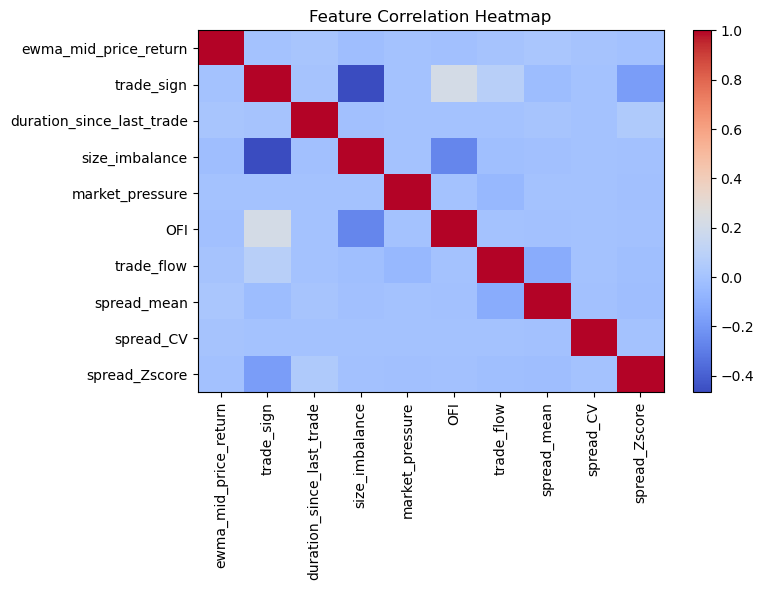

In [13]:
plt.ion()
display(fig_corr_heatmap)

## Cumulative Return Analysis

The **Cumulative Return Time Series** reveals a negative performance profile, ultimately resulting in approximately a -0.07 cumulative loss. Despite the predictive accuracy of our model exceeding the random baseline (>50%), the strategy initially shows negative returns. Several factors may explain this result:

### Impact of Daily Volatility

- **High Intraday Volatility:**  
  Increased volatility can amplify transaction costs and slippage, resulting in higher losses per trade. Frequent signal fluctuations may lead to rapid trade entries and exits, compounding execution costs and reducing net profitability.

- **Low or Unusual Volatility Patterns:**  
  Conversely, unusually low volatility can produce minimal price changes insufficient to offset transaction costs, even when directional predictions are correct. A strategy calibrated for typical market conditions may thus underperform during atypically calm or erratic market periods.

### Short Back-test Duration

- **Limited Sample Size:**  
  A brief back-test may not accurately reflect long-run profitability, making it particularly sensitive to anomalous market events (e.g., macroeconomic announcements, unexpected news).

- **Variance in Performance:**  
  Short-duration tests inherently exhibit higher performance variance. Consequently, brief negative performance periods can misrepresent the strategy’s potential effectiveness over longer-term horizons.

### Interpretation and Next Steps

The observed negative returns in this limited test scenario do not invalidate the predictive model's overall capability. Instead, they highlight the importance of refining execution strategies and considering volatility dynamics to enhance long-term profitability.


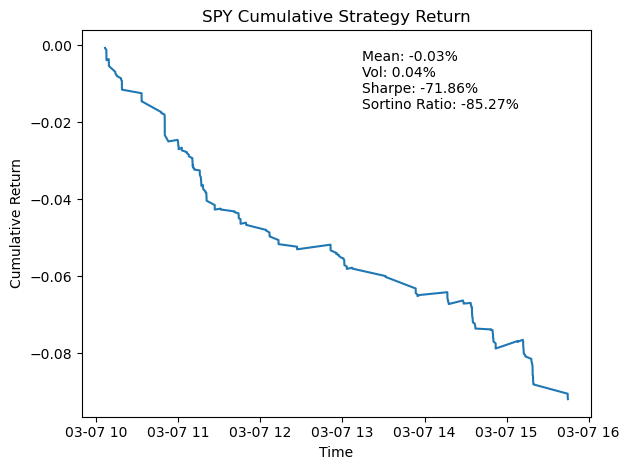

In [14]:
display(fig_cumulative_return)

## Analysis of Return Distribution

The **Distribution of Strategy Returns** plot indicates notable statistical characteristics typical of sign-trading strategies, specifically:

- **High Kurtosis:**  
  The observed high kurtosis indicates that return distributions have heavier tails and sharper peaks compared to a normal distribution. This reflects frequent small returns interspersed with occasional extreme outcomes, common in high-frequency trading environments.

- **Negative Skewness:**  
  The negative skew suggests a greater likelihood of occasional substantial negative returns, emphasizing that while most trades might produce small positive outcomes, infrequent large losses can disproportionately impact performance.

These characteristics align closely with theoretical expectations for sign-trading strategies, reinforcing the importance of rigorous risk management and execution optimization to mitigate the impact of negative tail events.


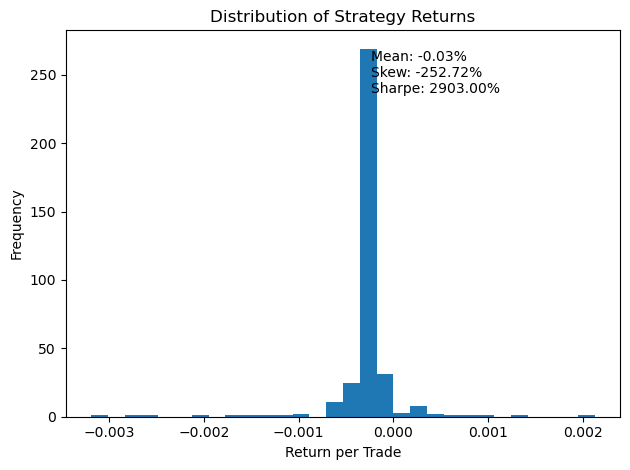

In [15]:
display(fig_dist_returns)

### Strategy Drawdown Analysis

The drawdown plot visualizes the magnitude and duration of declines from the historical peak of cumulative returns, highlighting the periods of greatest downside experienced by the strategy. Understanding the strategy's drawdown characteristics is crucial because it informs how we can effectively implement risk management techniques, such as stop-loss orders, position-sizing rules, or dynamic rebalancing to mitigate large losses.

Given the strategy's demonstrated **negative skewness and high kurtosis**, it experiences frequent minor gains accompanied by rare but significant losses. This statistical behavior makes careful management of downside risk especially important. By thoroughly analyzing drawdowns, we can better anticipate potential future losses and optimize our risk control strategies, significantly contributing to the overall robustness and long-term success of the trading approach.

Key takeaways:

- Drawdown analysis is critical for identifying potential weaknesses and stress-testing the strategy.
- Due to the strategy’s negative skew and high kurtosis, managing **downside risk** is paramount for sustained profitability and protection against severe market downturns.


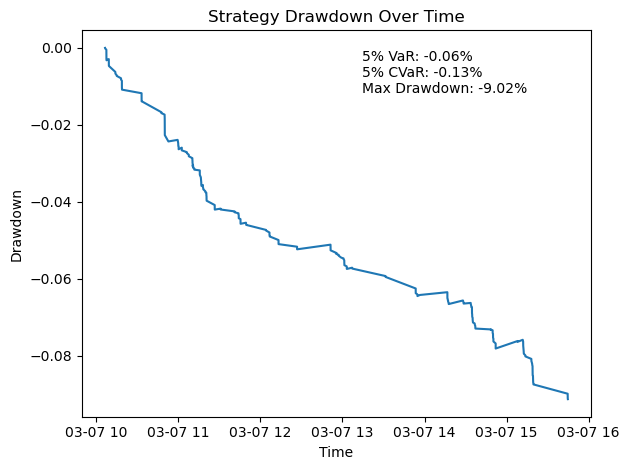

In [16]:
display(fig_drawdown)

### Distribution of Predicted Trade Signals

The distribution of predicted trading signals shows a clear predominance of **neutral signals**, indicating that the model frequently does not detect decisive trading opportunities. Among actionable signals, **sell signals significantly outnumber buy signals**, highlighting a strong tendency of the model to signal bearish market conditions or suggest exiting positions more often than entering. This imbalance could reflect either the model's conservative risk preferences or prevailing market sentiment during the analyzed period.

Key takeaways:
- **Neutral signals** dominate, showing frequent indecision or balanced market conditions.
- Strong bias towards **sell signals**, suggesting caution or bearishness in model-generated strategies.

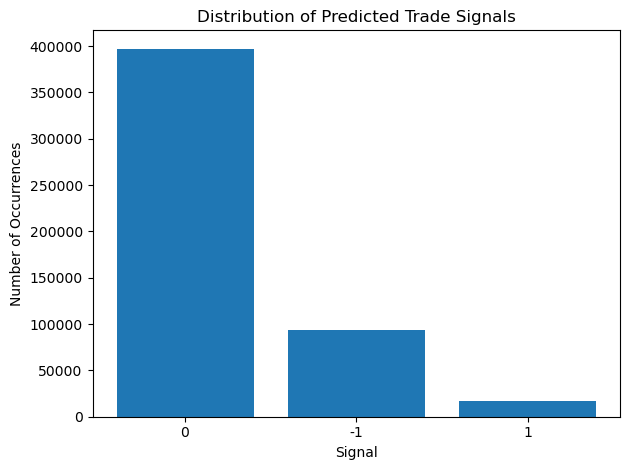

In [17]:
display(fig_signal_distribution)

### Mid Price with Signal Background Shading

This plot shows the mid-price of the asset throughout the trading period, with shaded background regions indicating when the model generated **buy (green)** or **sell (red)** signals. The visual representation clearly demonstrates the timing and duration of the algorithm's trading signals, allowing us to intuitively understand its behavior relative to price movements.

By highlighting these intervals, we can assess:

- **When** the model actively identifies entry (buy) and exit or shorting (sell) opportunities.
- **How effectively** the model's signals correspond with favorable price movements.

This visualization helps interpret the model’s decision-making and evaluate the timing and alignment of its signals against market conditions.


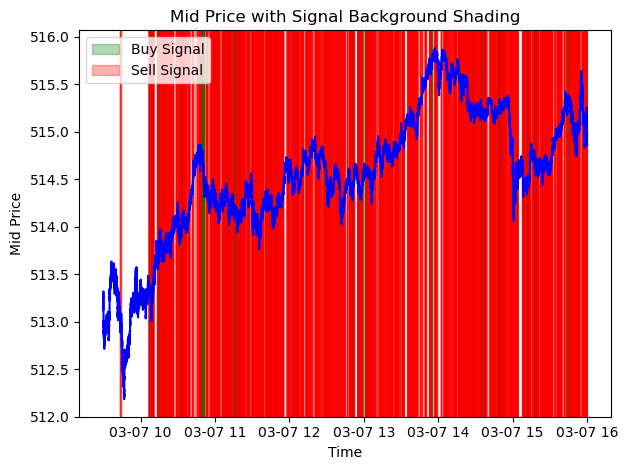

In [18]:
display(fig_midprice_signal_shaded)

### Sensitivity Analysis

Sensitivity analysis involves systematically varying key parameters of our trading model to observe their impact on strategy performance. This step is critical because it helps us understand which inputs significantly affect our results, identifying parameters that require precise tuning. By conducting sensitivity analysis, we can increase the robustness and reliability of the strategy, ensuring that performance is consistent even as market conditions shift or underlying assumptions change.

Key benefits:

- Highlights influential parameters driving strategy outcomes.
- Enhances understanding of strategy robustness to input variations.
- Guides effective parameter selection and risk management strategies.

### Sensitivity Analysis: Transaction Costs

Analyzing the sensitivity of our strategy to transaction costs is especially critical given its ultra-high-frequency nature. In high-frequency trading, transaction costs—including commissions, fees, and market impact—can constitute a substantial portion of the total profit and loss (PnL). Even slight changes in these costs can drastically alter profitability, potentially turning an otherwise profitable strategy into a losing one. 

Through this sensitivity analysis, we can clearly identify the threshold levels of transaction costs that our strategy can sustain, allowing us to:

- Determine break-even transaction cost levels for profitability.
- Optimize trade frequency and execution to minimize cost impacts.
- Better understand how sensitive our overall returns are to small fluctuations in transaction-related expenses.

This insight is essential for robust strategy implementation and achieving consistent long-term profitability.


In [ ]:
plt.ioff()
base_params = {
        "buy_threshold_std": 1.0,
        "sell_threshold_std": 1.0,
        "transaction_cost": 0.0001,
        "half_life_s": 60,
        "use_pca": False,
        "train_size": 0.8,
        "lookahead_timedelta": pd.Timedelta("1ms")
    }

trade_date = "2024-03-07"
ticker = 'SPY'

# Sensitivity to Trading Costs
param_values_transaction_cost = {"transaction_cost": [0, 0.00005, 0.0001, 0.0005, 0.001]}
results_tc = single_param_sensitivity(
    ticker='SPY',
    trade_date='2024-03-07',
    use_file=True,
    file_path=str(PROCESSED_DATA_DIR) + '/merged_trades.csv',
    base_params=base_params,
    param_values_dict=param_values_transaction_cost,
    base_model_name='sensitivity_transaction_cost'
)
results_tc.plot(x='transaction_cost', y='final_return', marker='o',
                title="Sensitivity to Trading Costs", xlabel="Transaction Costs", ylabel="Final Returns")


=== Varying 'transaction_cost' => 0 ===
Loading merged trades data from /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/data/processed/merged_trades.csv.
[sensitivity_transaction_cost_transaction_cost=0] Model not found at /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/models/sensitivity_transaction_cost_transaction_cost=0.pkl. Training a new one...
Fitting 20 folds for each of 2 candidates, totalling 40 fits


[Memory(location=/Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/cache/joblib)]: Flushing completely the cache



--- Final Model Performance ---
Best hyperparameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 50, 'rf__max_depth': 8}
Accuracy:
  Train: 81.30%
  Test:  82.15%
F1-Score:
  Train: 88.96%
  Test:  87.50%
Model saved to: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/models/sensitivity_transaction_cost_transaction_cost=0.pkl
-------------------------------------------
Ticker: SPY
Date:   2024-03-07
Model:  sensitivity_transaction_cost_transaction_cost=0
Final strategy cumulative return =  -0.0242
Average trade return           =  -0.000067
Std of trade returns           =  0.000369
-------------------------------------------
Plots saved in: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/src/data/results/sensitivity_transaction_cost_transaction_cost=0

=== Varying 'transaction_cost' => 5e-05 ===
Loading merged trades data from /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/data/processed/merged_trades.csv.
[sensit

[Memory(location=/Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/cache/joblib)]: Flushing completely the cache



--- Final Model Performance ---
Best hyperparameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 50, 'rf__max_depth': 8}
Accuracy:
  Train: 81.30%
  Test:  82.15%
F1-Score:
  Train: 88.96%
  Test:  87.50%
Model saved to: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/models/sensitivity_transaction_cost_transaction_cost=5e-05.pkl
-------------------------------------------
Ticker: SPY
Date:   2024-03-07
Model:  sensitivity_transaction_cost_transaction_cost=5e-05
Final strategy cumulative return =  -0.0585
Average trade return           =  -0.000166
Std of trade returns           =  0.000369
-------------------------------------------
Plots saved in: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/src/data/results/sensitivity_transaction_cost_transaction_cost=5e-05

=== Varying 'transaction_cost' => 0.0001 ===
Loading merged trades data from /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/data/processed/merged_trades

<Axes: title={'center': 'Sensitivity to Trading Costs'}, xlabel='Transaction Costs', ylabel='Final Returns'>

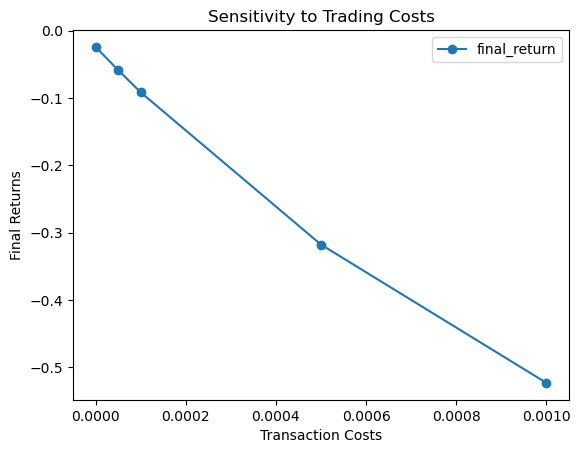

In [ ]:
results_tc['transaction_cost_bps'] = results_tc['transaction_cost'] * 10_000  # Convert to basis points (1 bp = 0.0001)

results_tc.plot(
    x='transaction_cost_bps', 
    y='final_return', 
    marker='o', 
    title="Sensitivity to Trading Costs", 
    xlabel="Transaction Costs (bps)", 
    ylabel="Final Returns"
)

### Sensitivity Analysis: Trade Execution Latency

Analyzing sensitivity to trade execution latency—the time between signal generation and actual trade execution—is particularly important for our ultra-high-frequency strategy. Because we operate over extremely short holding periods, even small delays can significantly impact our returns, exposing trades to adverse market movements before execution occurs. This latency risk can drastically alter profitability, turning optimal entry and exit points into missed opportunities or losses.

Understanding how sensitive our strategy is to varying levels of execution latency allows us to:

- Clearly identify how delays affect profitability and risk exposure.
- Implement measures to optimize execution speed, reducing market risk.
- Enhance our trade infrastructure to protect PnL against adverse market moves during critical execution windows.

Reducing and carefully managing latency is vital for maintaining the competitive advantage and profitability of our high-frequency approach.


In [ ]:
plt.ioff()
# Sensitivity to Lookahead Timedelta
param_values_lookahead = {
    "lookahead_timedelta": [
        pd.Timedelta("1ms"), 
        pd.Timedelta("10ms"), 
        pd.Timedelta("50ms"), 
        pd.Timedelta("100ms"), 
    ]
}

results_lookahead = single_param_sensitivity(
    ticker=ticker,
    trade_date=trade_date,
    use_file=True,
    file_path=str(PROCESSED_DATA_DIR) + '/merged_trades.csv',
    base_params=base_params,
    param_values_dict=param_values_lookahead,
    base_model_name='sensitivity_lookahead'
)

results_lookahead['lookahead_ms'] = results_lookahead['lookahead_timedelta'].dt.total_seconds() * 1000


=== Varying 'lookahead_timedelta' => 0 days 00:00:00.001000 ===
Loading merged trades data from /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/data/processed/merged_trades.csv.
[sensitivity_lookahead_lookahead_timedelta=0 days 00:00:00.001000] Found existing model at /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/models/sensitivity_lookahead_lookahead_timedelta=0 days 00:00:00.001000.pkl. Loading it.
-------------------------------------------
Ticker: SPY
Date:   2024-03-07
Model:  sensitivity_lookahead_lookahead_timedelta=0 days 00:00:00.001000
Final strategy cumulative return =  -0.0916
Average trade return           =  -0.000264
Std of trade returns           =  0.000368
-------------------------------------------
Plots saved in: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/src/data/results/sensitivity_lookahead_lookahead_timedelta=0 days 00:00:00.001000

=== Varying 'lookahead_timedelta' => 0 days 00:00:00.010000 =

[Memory(location=/Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/cache/joblib)]: Flushing completely the cache



--- Final Model Performance ---
Best hyperparameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 50, 'rf__max_depth': 8}
Accuracy:
  Train: 81.30%
  Test:  82.15%
F1-Score:
  Train: 88.96%
  Test:  87.50%
Model saved to: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/models/sensitivity_lookahead_lookahead_timedelta=0 days 00:00:00.050000.pkl
-------------------------------------------
Ticker: SPY
Date:   2024-03-07
Model:  sensitivity_lookahead_lookahead_timedelta=0 days 00:00:00.050000
Final strategy cumulative return =  -0.0914
Average trade return           =  -0.000263
Std of trade returns           =  0.000368
-------------------------------------------
Plots saved in: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/src/data/results/sensitivity_lookahead_lookahead_timedelta=0 days 00:00:00.050000

=== Varying 'lookahead_timedelta' => 0 days 00:00:00.100000 ===
Loading merged trades data from /Users/willduckett/Documents/GitHub/

[Memory(location=/Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/cache/joblib)]: Flushing completely the cache



--- Final Model Performance ---
Best hyperparameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 50, 'rf__max_depth': 8}
Accuracy:
  Train: 81.30%
  Test:  82.15%
F1-Score:
  Train: 88.96%
  Test:  87.50%
Model saved to: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/models/sensitivity_lookahead_lookahead_timedelta=0 days 00:00:00.100000.pkl
-------------------------------------------
Ticker: SPY
Date:   2024-03-07
Model:  sensitivity_lookahead_lookahead_timedelta=0 days 00:00:00.100000
Final strategy cumulative return =  -0.0919
Average trade return           =  -0.000265
Std of trade returns           =  0.000366
-------------------------------------------
Plots saved in: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/src/data/results/sensitivity_lookahead_lookahead_timedelta=0 days 00:00:00.100000

=== Varying 'lookahead_timedelta' => 0 days 00:00:00.500000 ===
Loading merged trades data from /Users/willduckett/Documents/GitHub/

[Memory(location=/Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/cache/joblib)]: Flushing completely the cache



--- Final Model Performance ---
Best hyperparameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 50, 'rf__max_depth': 8}
Accuracy:
  Train: 81.30%
  Test:  82.15%
F1-Score:
  Train: 88.96%
  Test:  87.50%
Model saved to: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/models/sensitivity_lookahead_lookahead_timedelta=0 days 00:00:00.500000.pkl
-------------------------------------------
Ticker: SPY
Date:   2024-03-07
Model:  sensitivity_lookahead_lookahead_timedelta=0 days 00:00:00.500000
Final strategy cumulative return =  -0.0923
Average trade return           =  -0.000266
Std of trade returns           =  0.000371
-------------------------------------------
Plots saved in: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/src/data/results/sensitivity_lookahead_lookahead_timedelta=0 days 00:00:00.500000
Saved plot: data/results/param_sensitivity/sensitivity_lookahead_timedelta.png


<Axes: title={'center': 'Sensitivity to Lookahead Timedelta'}, xlabel='Lookahead Timedelta (ms)', ylabel='Final Returns'>

<Axes: title={'center': 'Sensitivity to Lookahead Timedelta'}, xlabel='Lookahead Timedelta (ms)', ylabel='Final Returns'>

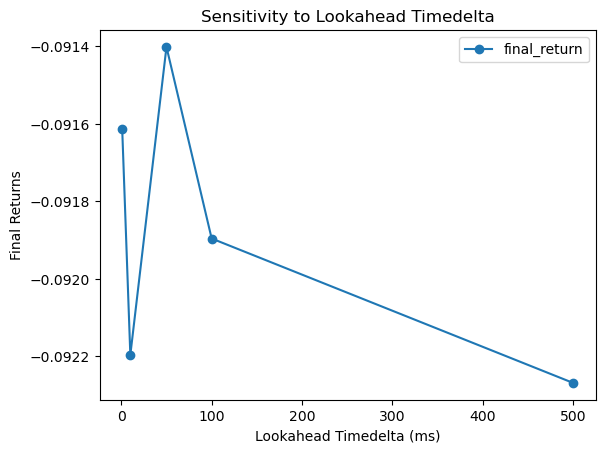

In [ ]:
plt.ion()
results_lookahead.plot(
    x='lookahead_ms',
    y='final_return',
    marker='o',
    title="Sensitivity to Lookahead Timedelta",
    xlabel="Lookahead Timedelta (ms)",
    ylabel="Final Returns"
)

### Sensitivity Analysis: Trade Signal Thresholds

Trade execution is triggered when the model's predicted future return surpasses a specified threshold. This threshold defines how selective the strategy is in taking trades, directly influencing trading frequency and risk-adjusted returns.

We test the following configurations:

- **Conservative Threshold (±2σ):** Trades occur only for extreme signals, reducing trade frequency but increasing precision.
- **Standard Threshold (±1σ):** The default setting, balancing execution frequency and reliability.
- **Aggressive Threshold (±0.5σ):** Trades occur frequently with a lower confidence threshold, increasing exposure but also risk.

Understanding sensitivity to trade signal thresholds is essential because it helps us:

- **Optimize the balance between precision and trading frequency.**  
- **Reduce false signals while maintaining sufficient trade volume.**  
- **Enhance risk-adjusted returns by calibrating entry/exit aggressiveness.**  

Adjusting these thresholds allows us to fine-tune the strategy based on market conditions and execution constraints.


In [ ]:
plt.ioff()
# Sensitivity to Trade Signal Thresholds
param_values_signal_thresholds = {  # Conservative, Standard, Aggressive
    "sell_threshold_std": [2.0, 1.0, 0.5]
}

results_signal_thresholds = single_param_sensitivity(
    ticker=ticker,
    trade_date=trade_date,
    use_file=True,
    file_path=str(PROCESSED_DATA_DIR) + '/merged_trades.csv',
    base_params=base_params,
    param_values_dict=param_values_signal_thresholds,
    base_model_name='sensitivity_signal_thresholds'
)


=== Varying 'sell_threshold_std' => 2.0 ===
Loading merged trades data from /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/data/processed/merged_trades.csv.
[sensitivity_signal_thresholds_sell_threshold_std=2.0] Model not found at /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/models/sensitivity_signal_thresholds_sell_threshold_std=2.0.pkl. Training a new one...
Fitting 20 folds for each of 2 candidates, totalling 40 fits


[Memory(location=/Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/cache/joblib)]: Flushing completely the cache



--- Final Model Performance ---
Best hyperparameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 50, 'rf__max_depth': 8}
Accuracy:
  Train: 86.74%
  Test:  86.54%
F1-Score:
  Train: 92.28%
  Test:  90.01%
Model saved to: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/models/sensitivity_signal_thresholds_sell_threshold_std=2.0.pkl
-------------------------------------------
Ticker: SPY
Date:   2024-03-07
Model:  sensitivity_signal_thresholds_sell_threshold_std=2.0
Final strategy cumulative return =  -0.0818
Average trade return           =  -0.000282
Std of trade returns           =  0.000364
-------------------------------------------
Plots saved in: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/src/data/results/sensitivity_signal_thresholds_sell_threshold_std=2.0

=== Varying 'sell_threshold_std' => 1.0 ===
Loading merged trades data from /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/data/processed/merged_trad

[Memory(location=/Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/cache/joblib)]: Flushing completely the cache



--- Final Model Performance ---
Best hyperparameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 50, 'rf__max_depth': 8}
Accuracy:
  Train: 81.30%
  Test:  82.15%
F1-Score:
  Train: 88.96%
  Test:  87.50%
Model saved to: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/models/sensitivity_signal_thresholds_sell_threshold_std=1.0.pkl
-------------------------------------------
Ticker: SPY
Date:   2024-03-07
Model:  sensitivity_signal_thresholds_sell_threshold_std=1.0
Final strategy cumulative return =  -0.0916
Average trade return           =  -0.000264
Std of trade returns           =  0.000368
-------------------------------------------
Plots saved in: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/src/data/results/sensitivity_signal_thresholds_sell_threshold_std=1.0

=== Varying 'sell_threshold_std' => 0.5 ===
Loading merged trades data from /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/data/processed/merged_trad

[Memory(location=/Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/cache/joblib)]: Flushing completely the cache



--- Final Model Performance ---
Best hyperparameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 50, 'rf__max_depth': 8}
Accuracy:
  Train: 72.32%
  Test:  74.39%
F1-Score:
  Train: 82.60%
  Test:  82.35%
Model saved to: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/_output/models/sensitivity_signal_thresholds_sell_threshold_std=0.5.pkl
-------------------------------------------
Ticker: SPY
Date:   2024-03-07
Model:  sensitivity_signal_thresholds_sell_threshold_std=0.5
Final strategy cumulative return =  -0.1056
Average trade return           =  -0.000262
Std of trade returns           =  0.000349
-------------------------------------------
Plots saved in: /Users/willduckett/Documents/GitHub/quant-trading-final-project-2/src/data/results/sensitivity_signal_thresholds_sell_threshold_std=0.5
Saved plot: data/results/param_sensitivity/sensitivity_sell_threshold_std.png


<Axes: title={'center': 'Sensitivity to Trade Signal Thresholds'}, xlabel='Trade Signal Threshold (Standard Deviations)', ylabel='Final Returns'>

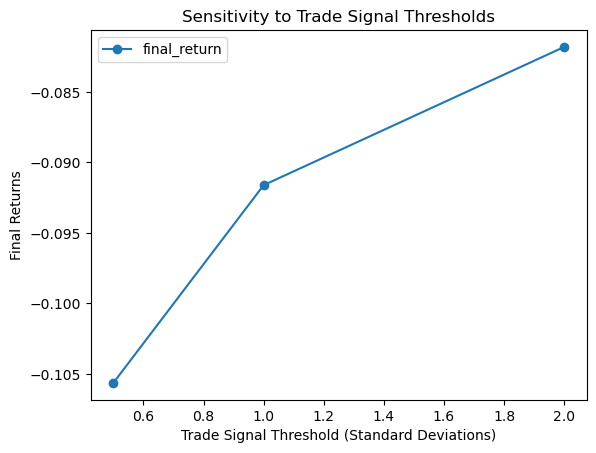

In [ ]:
plt.ion()
results_signal_thresholds.plot(
    x="sell_threshold_std",
    y="final_return",
    marker='o',
    title="Sensitivity to Trade Signal Thresholds",
    xlabel="Trade Signal Threshold (Standard Deviations)",
    ylabel="Final Returns"
)